# **Exploring data for each cluster**

**Importing modules + dataframes**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mp_api.client import MPRester
from pymatgen.analysis.pourbaix_diagram import PourbaixDiagram
from pymatgen.analysis.pourbaix_diagram import PourbaixPlotter
from IPython.display import display

# Importing all datasets
cluster_1 = pd.read_csv(r'Cluster_0.csv')
cluster_2 = pd.read_csv(r'Cluster_1.csv')
cluster_3 = pd.read_csv(r'Cluster_2.csv')
cluster_4 = pd.read_csv(r'Cluster_3.csv')
cluster_5 = pd.read_csv(r'Cluster_4.csv')

**Determining which cluster is assigned**

In [9]:
#Function to find minimum overpotential in a dataset
def print_min(data):
    print(data["Overpotential at xx (nearby) current density vs RHE, V"].min())
print_min(cluster_1)
print_min(cluster_2)
print_min(cluster_3)
print_min(cluster_4)
print_min(cluster_5)
df_list = [cluster_1,cluster_2,cluster_3,cluster_4,cluster_5]

1.36
0.26
1.89
1.09
0.81


In [10]:
# Assigning clusters

def assign_clusters(df_list):
    for data in df_list:
        if data["Overpotential at xx (nearby) current density vs RHE, V"].min() == 1.89:
            left_data = data
        elif data["Overpotential at xx (nearby) current density vs RHE, V"].min() == 1.09:
            middle_left = data
        elif data["Overpotential at xx (nearby) current density vs RHE, V"].min() == 0.81:
            middle_right = data
        elif data["Overpotential at xx (nearby) current density vs RHE, V"].min() == 0.26:
            optimum_region = data
        else:
            right_data = data
    new_df_list = [left_data,middle_left,middle_right,optimum_region,right_data]
    return new_df_list

new_df_list = assign_clusters(df_list)
#print(new_df_list)

var_names = ["left_data", "middle_left", "middle_right", "optimum_region", "right_data"]
vars_dict = dict(zip(var_names, new_df_list))
left_data = vars_dict["left_data"]
middle_left= vars_dict["middle_left"]
middle_right = vars_dict["middle_right"]
optimum_region = vars_dict["optimum_region"]
right_data = vars_dict["right_data"]


**Finding composition data on each dataframe**

In [11]:
#Function to produce a df of counts for every element within each datafram
def retrieve_composition_df(df):
    comp_list = list(df['composition'])
    ind_element = []
    for i in comp_list:
        ind_element+=i.split()
    [[x,ind_element.count(x)] for x in set(ind_element)]
    ind_element_dic =  dict((x,ind_element.count(x)) for x in set(ind_element))
    ind_element_df = pd.DataFrame.from_dict(ind_element_dic, orient = 'index', columns=['Count'])
    ind_element_df= ind_element_df.reset_index(names=['Element'])
    ind_element_df = ind_element_df.sort_values(by = 'Count', ascending=False, ignore_index=True)
    #display(ind_element_df)
    return ind_element_df


In [12]:
#Bar chart plot to visualise the number of elements in each region, +saving figures
def bar_chart_element_count(df1,df2,df3,df4,df5):
    df_list = [df1,df2,df3,df4,df5]
    for i in range(0,len(df_list)):
        title_lst = ['Optimum region','Left side','Middle left','Middle right', 'Right side']
        df = df_list[i].loc[1:12,:]
        fig, ax = plt.subplots()
        ax.bar(x=df['Element'], height=df['Count'])
        ax.set_title(title_lst[i])
        ax.set_xlabel('Element')
        ax.set_ylabel('Count')
        fig.savefig(title_lst[i]+'.png', bbox_inches='tight')


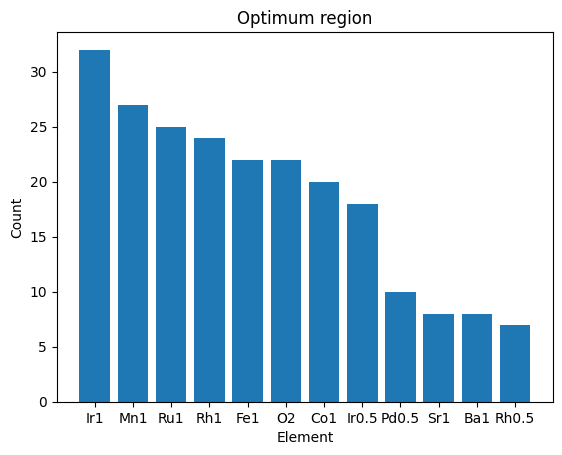

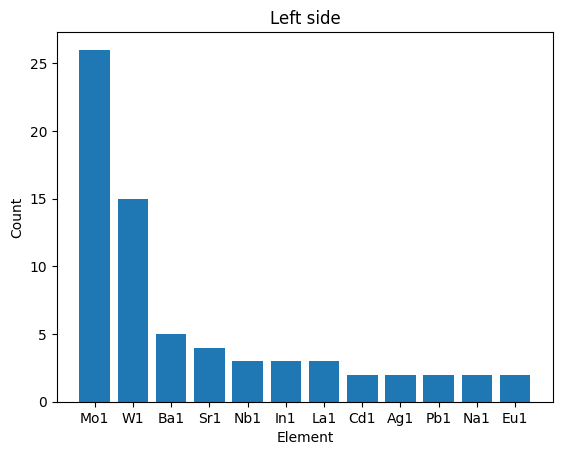

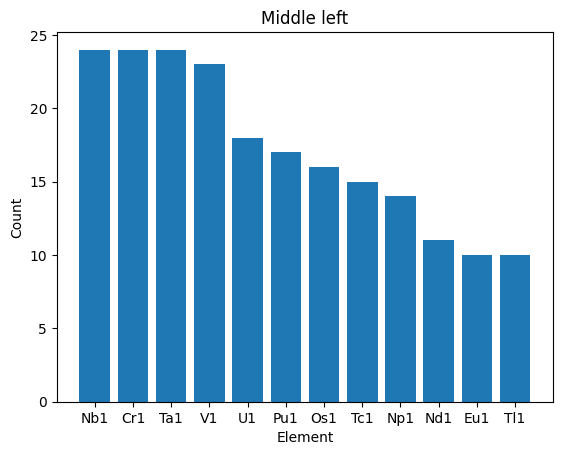

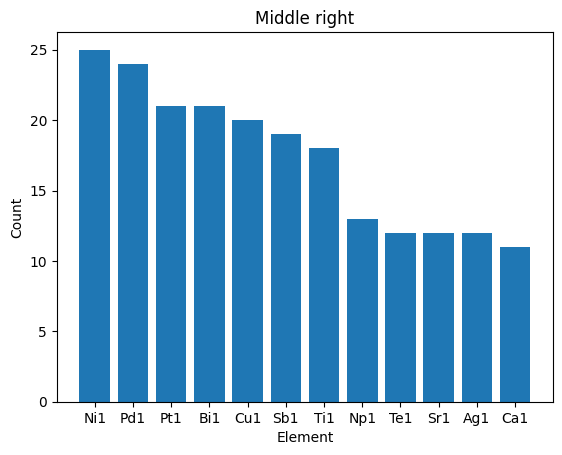

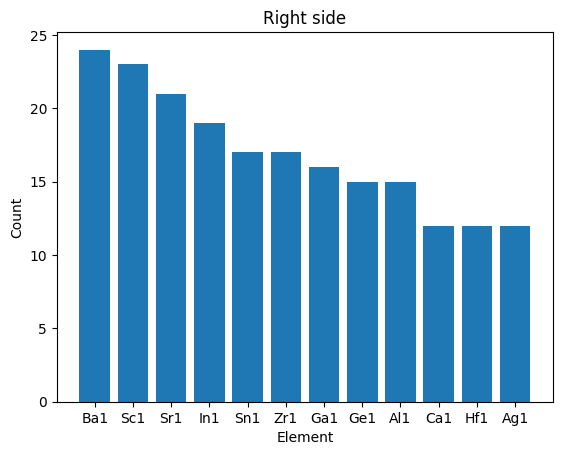

In [13]:

element_df_optimum =  retrieve_composition_df(optimum_region)
element_df_left =  retrieve_composition_df(left_data)
element_df_middle_left =  retrieve_composition_df(middle_left)
element_df_middle_right =  retrieve_composition_df(middle_right)
element_df_right =  retrieve_composition_df(right_data)
bar_chart_element_count(element_df_optimum,element_df_left,element_df_middle_left,element_df_middle_right,element_df_right)

**Analysing if elements are spread or concentrated in one region**

In [14]:
#Adding new column names
title_lst = ['Optimum region','Left side','Middle left','Middle right', 'Right side']

element_df_optimum['Region'] = 'Optimum region'
element_df_left['Region'] = 'Left side'
element_df_middle_left['Region'] =  'Middle left'
element_df_middle_right['Region'] = 'Middle right'
element_df_right['Region'] = 'Right side'

In [15]:
#Combining datasets 
combined_element_df = pd.concat([element_df_optimum,element_df_left,element_df_middle_left,element_df_middle_right,element_df_right])
combined_element_df = combined_element_df.pivot_table(
                        values='Count',
                        index='Element',
                        columns='Region',
                        fill_value=0,
                        aggfunc= sum,
                        margins=True)
#combined_element_df.to_excel('Element analysis file.xlsx')

**Generating pourbaix diagrams**

Retrieving ThermoDoc documents: 100%|██████████| 270/270 [00:00<?, ?it/s]


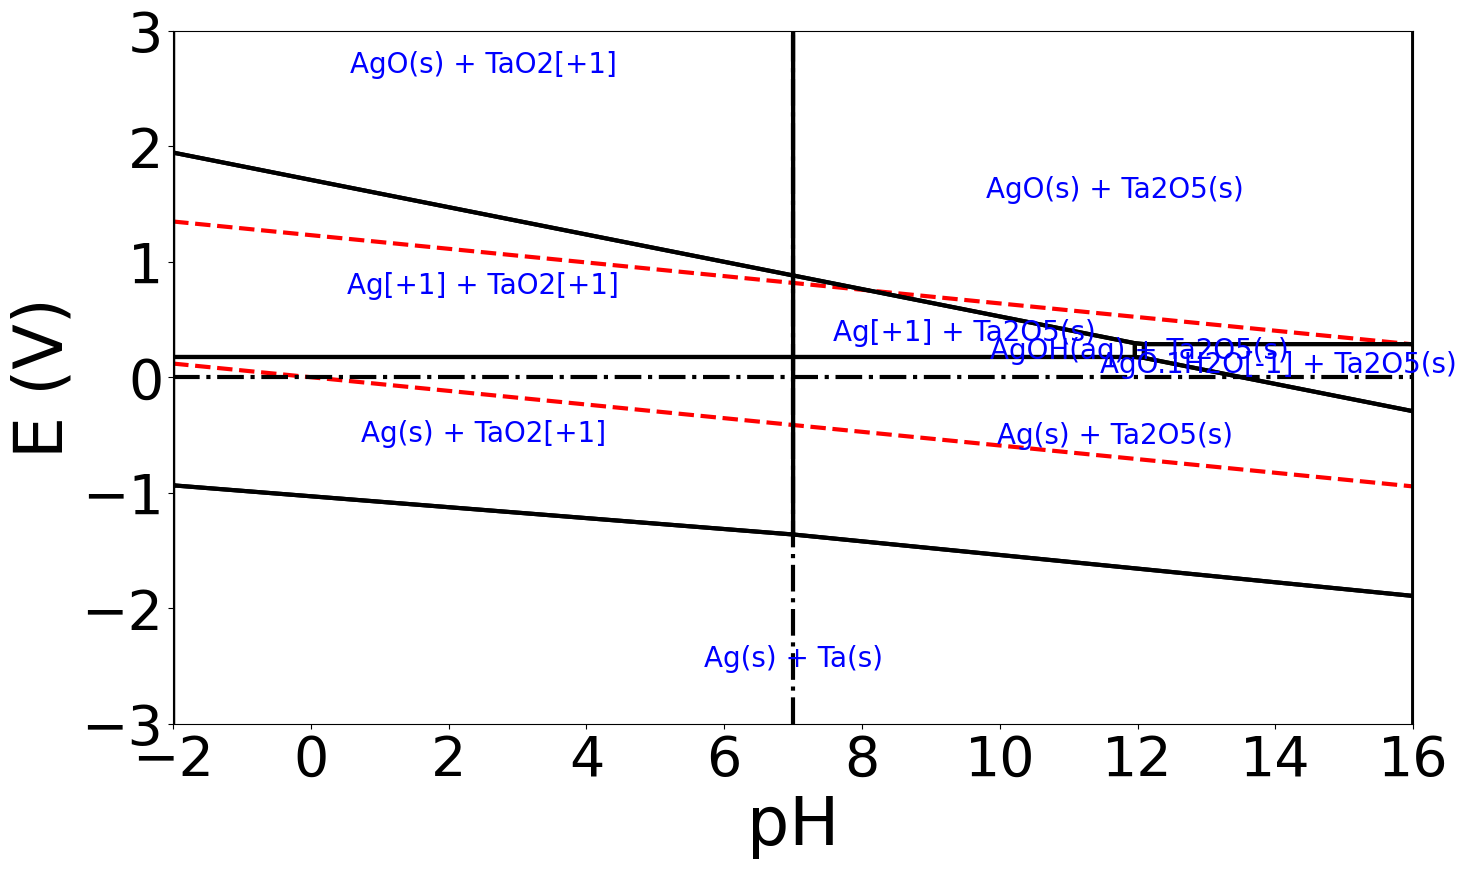

In [34]:
#Code to generate a pourbaix diagram
with MPRester(api_key='CmGarHKLtPCjVpEkivPDYkhRJKJiB8A7') as mpr:
    pourbaix_entries = mpr.get_pourbaix_entries('Ag-O-Ta')
pd = PourbaixDiagram(pourbaix_entries)
plotter = PourbaixPlotter(pd)
PourbaixPlotter.get_pourbaix_plot(plotter,limits=[[-2, 16],[-3, 3]])
plt.savefig('plotter.png',bbox_inches='tight')